# Lathe Operational Mode Determination

<br>

[Kirovsky Zavod](https://kzgroup.ru/eng/s/2/about_the_company.html) (KZ) is one of Saint-Petersburg's largest manufacturing enterprises.<br> Hoping for a luck, I've asked a CIO of KZ for any work for newbie in Data Science.

As it turned out, people there are still using industrial equipment which is quite old.<br> 
IT department attached up to 4 sensors to certain old model lathes in order to gather lathes data, with no purpose for now.<br> 

In this project we'll analyze a dataset with timestamps and matching data from sensors.<br>

As a possible finishing points of the project we'll set theese goals:
- determine operational mode (metal part is processed or not)
- defining operational mode over sensors measurement fluctuations
- applying clustering algorithms

## Getting Familiar With the Dataset

Dataset which was given by CIO is in CSV format and contains 6 columns:

![Dataframe view](data_view.png)
<br>
Columns description:
- **id** – data ID in system
- **id_equip** – lathe ID
- **chanel** – measurement channel, up to 4 channels per lathe is active
- **value** - channel measured values. It is presented in conventional units proportional to current lathe power consumption 
- **date_time** - time and date of measurement
</br>

We also have more detailed description over the gathered data:
1. Each lathe have from 1 to 4 sensors. Each channel corresponds to sensor. Measurements were taken once per second.
2. Sensors are attached to lathe shaft and they are measuring current drive load.
3. Power consumption and drive load are increasing when metal parts are processed on lathe. Amplitude fluctuations and outliers in data are results of that processing.
4. Multichannel data is, for example: channel 1 - metal part installed and turning fast or slow or turned for some angle and fixed, channel 2 - machining tool for metal part processing, channel 3 ... and etc. Overall lathe operation is a result of channel measurements.
5. Drive load is also depends on shaft turning speed.
6. Measures data is 'dirty' - some sensors are not power connected, some are not grounded.
---
Let's start from libraries and data import.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import matplotlib.dates as mdates

In [2]:
# Columns names from description above:
df = pd.read_csv("monitoring_data.csv", names=['id', 'id_equip', 'chanel', 'value', 'date_time'])

Dataset contains data only for 2020-01-23.

First we'll explore what data types we have in our dataframe and what are columns data ranges.

In [3]:
df.head()

,id,id_equip,chanel,value,date_time
0,1148809303,16,2,1,2020-01-23 12:20:06.000000
1,1148809302,16,1,542,2020-01-23 12:20:06.000000
2,1148809301,51,4,7,2020-01-23 12:20:06.000000
3,1148809300,51,3,4,2020-01-23 12:20:06.000000
4,1148809299,51,2,1,2020-01-23 12:20:06.000000


In [4]:
df.describe()

,id,id_equip,chanel,value
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000
mean,1.148309e+09,54.271308,2.186752,84.367476
std,2.886753e+05,12.539110,1.056603,177.783521
min,1.147809e+09,16.000000,1.000000,0.000000
25%,1.148059e+09,51.000000,1.000000,1.000000
50%,1.148309e+09,54.000000,2.000000,4.000000
75%,1.148559e+09,66.000000,3.000000,40.000000
max,1.148809e+09,72.000000,4.000000,1023.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   id         1000000 non-null  int64 
 1   id_equip   1000000 non-null  int64 
 2   chanel     1000000 non-null  int64 
 3   value      1000000 non-null  int64 
 4   date_time  1000000 non-null  object
dtypes: int64(4), object(1)
memory usage: 38.1+ MB


Columnn **date_time** we'll transform to *datetime* format for further data filtering purpose.

In [6]:
# Get rid of milliseconds first:
df['date_time'] = df['date_time'].apply(lambda x: x.split('.')[0])

# Formatting strings to proper datetime format:
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y%m%d %H:%M:%S')

# Sort by time and index resetting:
df = df.sort_values(by='date_time', ascending=True)
df = df.reset_index(drop=True)

# ID column contain discrete values corresponding only to plant manufacturing system ID stamp, so we'll drop it:
df = df.drop('id', axis=1)

df.head()

,id_equip,chanel,value,date_time
0,55,1,1,2020-01-23 07:29:37
1,59,1,0,2020-01-23 07:29:37
2,59,2,1023,2020-01-23 07:29:37
3,59,3,0,2020-01-23 07:29:37
4,70,1,1,2020-01-23 07:29:37


## Dataframe Exploration

Let's start from getting number of lathe ID's and number of channels per lathe.

In [7]:
# Lathe ID's and overall measurements per lathe:
df['id_equip'].value_counts()

68    70776
69    70732
59    70452
51    70392
52    70384
54    70344
53    70320
56    70076
55    70076
16    53213
41    53190
72    33404
70    33290
47    33260
44    33245
43    33228
49    33114
66    31312
67    29192
Name: id_equip, dtype: int64

In [8]:
# Channel per lathe:
for i in df['id_equip'].unique():
    select = df[df['id_equip'] == i]
    print('Lathe ID:', str(i) + ',', 
          'number of channels:', len(select['chanel'].unique()))

Lathe ID: 55, number of channels: 4
Lathe ID: 59, number of channels: 4
Lathe ID: 70, number of channels: 2
Lathe ID: 53, number of channels: 4
Lathe ID: 16, number of channels: 3
Lathe ID: 43, number of channels: 2
Lathe ID: 69, number of channels: 4
Lathe ID: 66, number of channels: 2
Lathe ID: 44, number of channels: 2
Lathe ID: 54, number of channels: 4
Lathe ID: 49, number of channels: 2
Lathe ID: 47, number of channels: 2
Lathe ID: 56, number of channels: 4
Lathe ID: 68, number of channels: 4
Lathe ID: 67, number of channels: 2
Lathe ID: 51, number of channels: 4
Lathe ID: 52, number of channels: 4
Lathe ID: 72, number of channels: 2
Lathe ID: 41, number of channels: 3


From previous *df.describe()* command we know measures range (from 0 to 1023). Let's see how target data (channel values) is distributed across our dataframe.

In [9]:
df['value'].value_counts(bins=20, normalize=True, sort=False) * 100

(-1.0239999999999998, 51.15]    77.3728
(51.15, 102.3]                   1.2940
(102.3, 153.45]                  2.7145
(153.45, 204.6]                  1.5507
(204.6, 255.75]                  1.9126
(255.75, 306.9]                  7.2904
(306.9, 358.05]                  0.1539
(358.05, 409.2]                  0.5088
(409.2, 460.35]                  1.0575
(460.35, 511.5]                  0.4493
(511.5, 562.65]                  2.8499
(562.65, 613.8]                  1.2100
(613.8, 664.95]                  0.0918
(664.95, 716.1]                  0.0539
(716.1, 767.25]                  0.0477
(767.25, 818.4]                  0.0466
(818.4, 869.55]                  0.0735
(869.55, 920.7]                  0.0566
(920.7, 971.85]                  0.0906
(971.85, 1023.0]                 1.1749
Name: value, dtype: float64

It will be better to visualize it.

In [10]:
# Creating colorblind-friendly colors:
cb_blue = (0/255, 114/255, 178/255)
cb_yellow = (219/255, 209/255, 0/255)
cb_green = (0/255, 158/255, 115/255)
cb_red = (146/255, 0/255, 0/255)

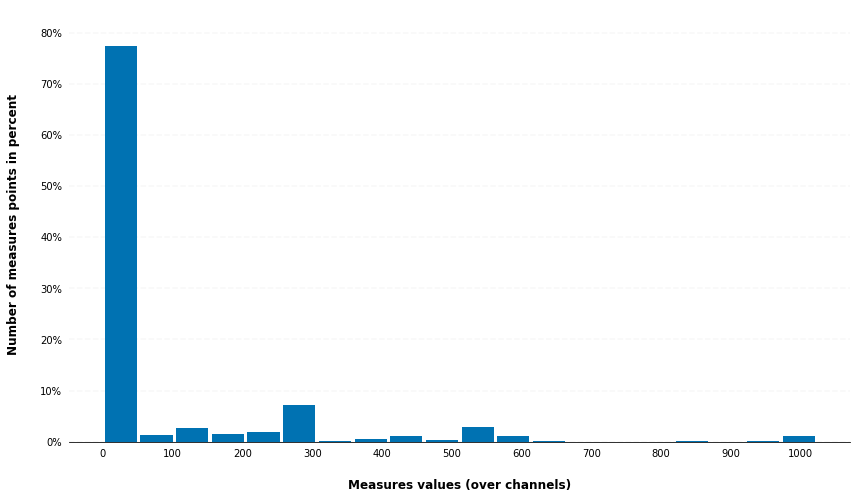

In [11]:
import matplotlib.ticker as mtick

ax = df.hist(column='value', bins=20, grid=False, figsize=(14,8), color=cb_blue, zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(bottom=False, top=False, left=False, right=False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set X-axis and Y-axis labels
    x.set_xlabel("Measures values (over channels)", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Number of measures points in percent", labelpad=20, weight='bold', size=12)
    
    # Set x-axis ticks
    x.set_xticks([i for i in range(0,1001, 100)])
    
    # Set y-axis ticks
    x.set_ylim(0,850000)
    x.yaxis.set_major_formatter(mtick.PercentFormatter(1000000))

Approximately 77 % of points are placed in range from 0 to 50. We can assume that all this time lathes were off or sensors were not connected properly. There are also several 'work' ranges 100-300 and 500-600. We need to perform detailed analysis across several lathes.

## Exploring Lathe Data

As an example we'll take lathe with id_equip **68** because there are 70776 data points for it which is the largest result.<br>
Let's see datapoints distribution for given time period.

In [12]:
# Here a copy of df needed for further manipulation:
df_68 = df[df['id_equip'] == 68].copy()
df_68 = df_68.reset_index(drop=True)

df_68

,id_equip,chanel,value,date_time
0,68,2,16,2020-01-23 07:29:38
1,68,3,3,2020-01-23 07:29:38
2,68,4,256,2020-01-23 07:29:38
3,68,1,20,2020-01-23 07:29:38
4,68,2,16,2020-01-23 07:29:39
...,...,...,...,...
70771,68,3,3,2020-01-23 12:20:04
70772,68,1,27,2020-01-23 12:20:05
70773,68,3,3,2020-01-23 12:20:05
70774,68,2,22,2020-01-23 12:20:05


We'll use scatterplot for visualization because we interested in data points distribution over time.

In [13]:
# Extacting channnnels for plotting:
df_68_1 = df_68[df_68['chanel'] == 1]
df_68_2 = df_68[df_68['chanel'] == 2]
df_68_3 = df_68[df_68['chanel'] == 3]
df_68_4 = df_68[df_68['chanel'] == 4]

Let's write a function that will help in visualization.

In [14]:
def lathe_data_vizual(masterDF, sub_df1, sub_df2, sub_df3, sub_df4, lathe_ID, model, 
                      model_pred=None, model_name=None, f_hour=7, f_minute=29, 
                      t_hour=12, t_minute=20):
    
    '''Function for visualizing data points on timestamps 
    
    Args:
        masterDF (DataFrame): upper dataframe with lathe ID.
        sub_df1..4 (DataFrame): channel dataframes for specific lathe. If model is using,
                                then just put the same dataframes here.
        lathe_ID (int): lathe ID from id_equip column.
        model (str): parameter for model plotting activation. States - 'm_on', 'm_off'.
        model_pred (Series): model prediction results. Default - None.
        model_name (str): model name for plot title. Default - None.
        f_hour (int): FROM what hour we plot, values from 1 to 24. Default - 7.
        f_minute (int): FROM what minute we plot, values from 1 to 59. Default - 29.
        t_hour (int): TO what hour we plot, values from 1 to 24. Default - 12.
        t_minute (int): TO what minute we plot, values from 1 to 59. Default - 20.
        
    Returns:
        plt(): scatter plot.
    
    '''
    
    # Format and time selection for X-axis:
    minutes = mdates.MinuteLocator(interval=30) # every 30 minutes
    times_fmt = mdates.DateFormatter('%H:%M')
    
    # Plot measurement points:
    fig, ax = plt.subplots(figsize=(24,12))
    if model == 'm_off':
        plt.scatter(sub_df1['date_time'], sub_df1['value'], label='Channel 1', color=cb_blue)
        plt.scatter(sub_df2['date_time'], sub_df2['value'], label='Channel 2', color=cb_yellow)
        plt.scatter(sub_df3['date_time'], sub_df3['value'], label='Channel 3', color=cb_green)
        plt.scatter(sub_df4['date_time'], sub_df4['value'], label='Channel 4', color=cb_red)
        
    if model == 'm_on':
        plt.scatter(sub_df1['date_time'], sub_df1['chanel_1'], c=model_pred)
        plt.scatter(sub_df2['date_time'], sub_df2['chanel_2'], c=model_pred)
        plt.scatter(sub_df3['date_time'], sub_df3['chanel_3'], c=model_pred)
        plt.scatter(sub_df4['date_time'], sub_df4['chanel_4'], c=model_pred)
        
    plt.xlim([dt.datetime(2020, 1, 23, f_hour, f_minute, 0), 
              dt.datetime(2020, 1, 23, t_hour, t_minute, 0)])
    
    # Adjusting plot info:
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Measurement Points', labelpad=20, weight='bold', size=16)
    
    if model == 'm_off':
        plt.title('Lathe ID-{} data for 2020-01-23'.format(lathe_ID), size=24)
    if model == 'm_on':
        plt.title('{} for lathe ID-{}'.format(model_name, lathe_ID), size=24)

    # Despining and removing ticks:
    ax.tick_params(top=False, right=False)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

    # Set proper X-axis labels view:
    ax.xaxis.set_major_locator(minutes)
    ax.xaxis.set_major_formatter(times_fmt)
    ax.format_xdata = mdates.DateFormatter('%H:%M')
    fig.autofmt_xdate()

    # Legend setup:
    if model == 'm_off':
        plt.legend(loc='best', fontsize=14)

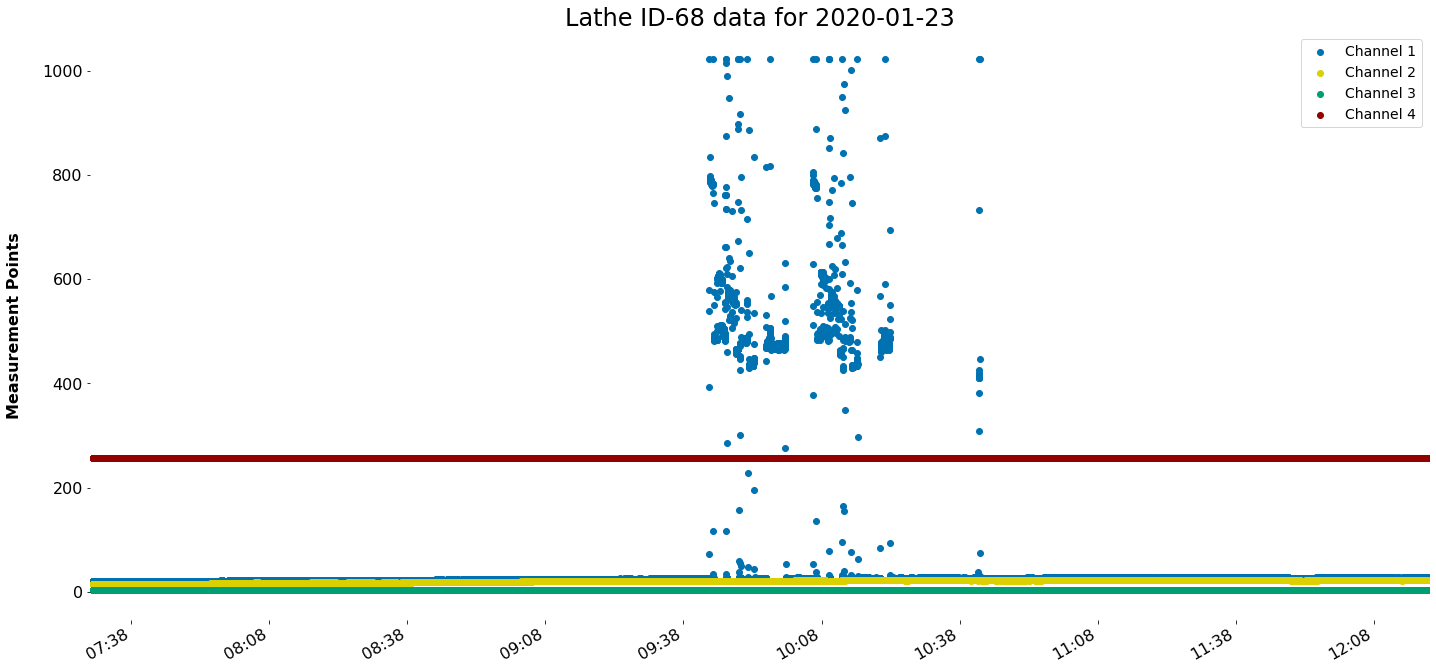

In [15]:
lathe_data_vizual(df_68, df_68_1, df_68_2, df_68_3, df_68_4, 68, 'm_off')

In [16]:
print(df_68_2['value'].mode(), '\n', 
      df_68_3['value'].mode(), '\n', 
      df_68_4['value'].mode())

0    22
dtype: int64 
 0    3
dtype: int64 
 0    256
dtype: int64


We can see that channels 2, 3 and 4 have constant values for every time point. Channel 1 is working properly, at least there are groups of datapoints which can be considered as valuable.

### 3. Operational Mode Determination

We can aquire operational mode ON/OFF (metal part processed/not processed) tag in different ways:
1. By manual assignment of border line (for example data STD - id data point is lower than STD = mode is 'OFF', otherwise = 'ON').
2. With help of an algorithm.
3. Manual data markup on visualized data.
4. By installing a camera on lathe which will give us a "metal part is processing" tag.

First variant is quite simple, but data points could "jump" near the border so we couldn't say for sure what operational mode was at that moment.
<br>
Third point is meaningless because in modern world we can use an algorithm.
<br>
Forth point is quite interesting in applying real time video analysis algorithms and it will give us clear understanding of current opearional mode, but for now KZ haven't got resources for such thing.

---
We'll operate with variant 2 - implement clustering algorithm for one of lathes data.

There is second lathe after ID-68 with large data points pool and at least 2 working sensors and it's **ID-52**.

In [17]:
df_52 = df[df['id_equip'] == 52].copy()
df_52 = df_52.reset_index(drop=True)

# Extacting channnnels for plotting:
df_52_1 = df_52[df_52['chanel'] == 1]
df_52_2 = df_52[df_52['chanel'] == 2]
df_52_3 = df_52[df_52['chanel'] == 3]
df_52_4 = df_52[df_52['chanel'] == 4]

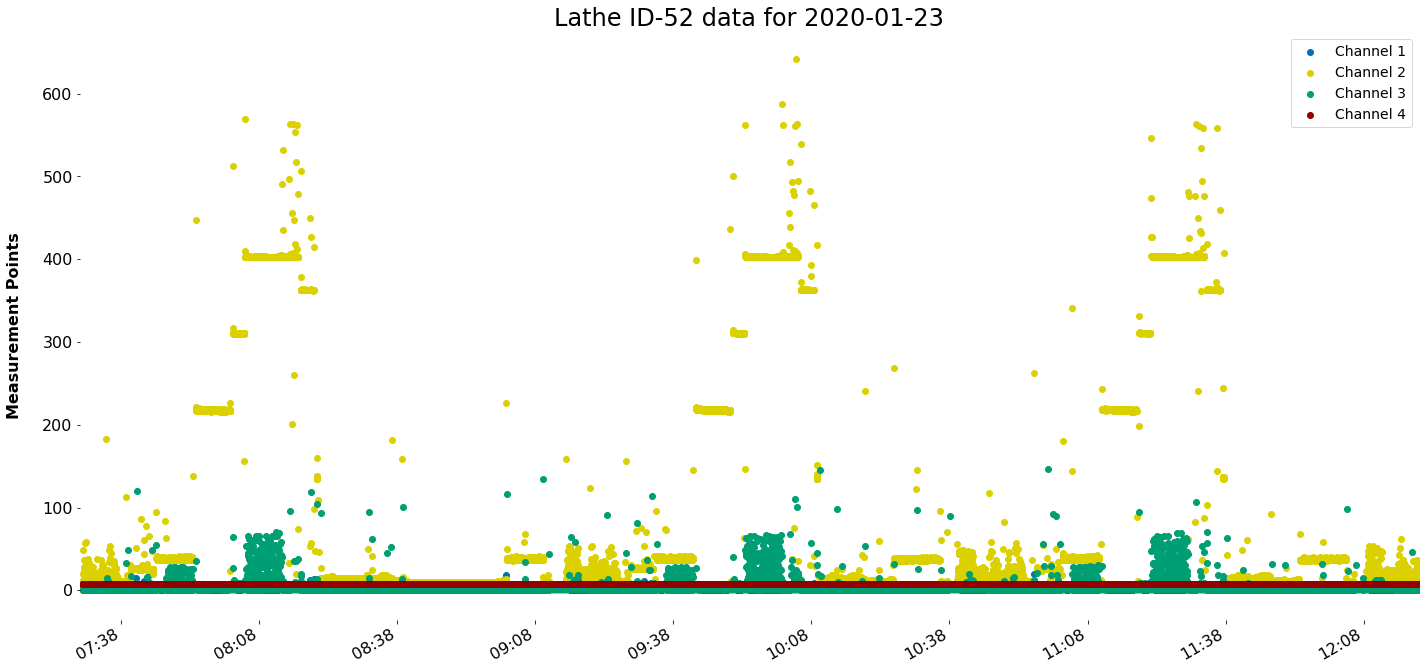

In [19]:
lathe_data_vizual(df_52, df_52_1, df_52_2, df_52_3, df_52_4, 52, 'm_off')

In [20]:
df_52_1['value'].value_counts(bins=20, normalize=True, sort=False) * 100

(-0.021, 1.0]    99.693112
(1.0, 2.0]        0.085247
(2.0, 3.0]        0.056831
(3.0, 4.0]        0.034099
(4.0, 5.0]        0.028416
(5.0, 6.0]        0.005683
(6.0, 7.0]        0.017049
(7.0, 8.0]        0.000000
(8.0, 9.0]        0.017049
(9.0, 10.0]       0.000000
(10.0, 11.0]      0.017049
(11.0, 12.0]      0.017049
(12.0, 13.0]      0.000000
(13.0, 14.0]      0.005683
(14.0, 15.0]      0.005683
(15.0, 16.0]      0.000000
(16.0, 17.0]      0.000000
(17.0, 18.0]      0.005683
(18.0, 19.0]      0.005683
(19.0, 20.0]      0.005683
Name: value, dtype: float64

In [21]:
df_52_2['value'].value_counts(bins=20, normalize=True, sort=False) * 100

(-0.643, 32.1]    57.064105
(32.1, 64.2]      18.418959
(64.2, 96.3]       0.125028
(96.3, 128.4]      0.039782
(128.4, 160.5]     0.255740
(160.5, 192.6]     0.017049
(192.6, 224.7]     7.700614
(224.7, 256.8]     0.034099
(256.8, 288.9]     0.017049
(288.9, 321.0]     2.500568
(321.0, 353.1]     0.011366
(353.1, 385.2]     2.693794
(385.2, 417.3]    10.797909
(417.3, 449.4]     0.073880
(449.4, 481.5]     0.073880
(481.5, 513.6]     0.056831
(513.6, 545.7]     0.028416
(545.7, 577.8]     0.079564
(577.8, 609.9]     0.005683
(609.9, 642.0]     0.005683
Name: value, dtype: float64

In [22]:
df_52_3['value'].value_counts(bins=20, normalize=True, sort=False) * 100

(-0.148, 7.35]     94.106615
(7.35, 14.7]        2.307343
(14.7, 22.05]       0.988861
(22.05, 29.4]       0.727438
(29.4, 36.75]       0.454649
(36.75, 44.1]       0.369402
(44.1, 51.45]       0.318254
(51.45, 58.8]       0.284155
(58.8, 66.15]       0.261423
(66.15, 73.5]       0.045465
(73.5, 80.85]       0.000000
(80.85, 88.2]       0.005683
(88.2, 95.55]       0.039782
(95.55, 102.9]      0.034099
(102.9, 110.25]     0.017049
(110.25, 117.6]     0.011366
(117.6, 124.95]     0.011366
(124.95, 132.3]     0.000000
(132.3, 139.65]     0.005683
(139.65, 147.0]     0.011366
Name: value, dtype: float64

In [23]:
df_52_4['value'].value_counts(bins=20, normalize=True, sort=False) * 100

(6.992900000000001, 6.9937]      0.0
(6.9937, 6.9944]                 0.0
(6.9944, 6.9951]                 0.0
(6.9951, 6.9958]                 0.0
(6.9958, 6.9965]                 0.0
(6.9965, 6.9972]                 0.0
(6.9972, 6.9979]                 0.0
(6.9979, 6.9986]                 0.0
(6.9986, 6.9993]                 0.0
(6.9993, 7.0]                  100.0
(7.0, 7.0007]                    0.0
(7.0007, 7.0014]                 0.0
(7.0014, 7.0021]                 0.0
(7.0021, 7.0028]                 0.0
(7.0028, 7.0035]                 0.0
(7.0035, 7.0042]                 0.0
(7.0042, 7.0049]                 0.0
(7.0049, 7.0056]                 0.0
(7.0056, 7.0063]                 0.0
(7.0063, 7.007]                  0.0
Name: value, dtype: float64

Channel 1: approximately 99.5 % of data points are around zero.<br>
Channel 2: working sensor with good data distribution, we can see lined datapoints - metal parts processing.<br>
Channel 3: several groups of data points from 5 to 100 with some outliers over 100.<br>
Channel 4: 100 % data is 7.

Let's use all 4 channels for clustering algorithm.

In [24]:
# We need new dataframe for algorithm:
df_52_model = pd.DataFrame()

# Resetting indexes for future merging:
df_52_1 = df_52_1.reset_index(drop=True)
df_52_2 = df_52_2.reset_index(drop=True)
df_52_3 = df_52_3.reset_index(drop=True)
df_52_4 = df_52_4.reset_index(drop=True)

In [25]:
# Combining all together:
df_52_model = pd.concat([df_52_1['value'], df_52_2['value'], df_52_3['value'], 
                       df_52_4['value']], axis=1, ignore_index=True)

In [26]:
# Final preparations:
df_52_model.columns = ['chanel_1', 'chanel_2', 'chanel_3', 'chanel_4']
df_52_model['date_time'] = df_52_1['date_time']
df_52_model.head()

,chanel_1,chanel_2,chanel_3,chanel_4,date_time
0,0,11,1,7,2020-01-23 07:29:38
1,0,11,1,7,2020-01-23 07:29:39
2,0,11,1,7,2020-01-23 07:29:40
3,0,49,1,7,2020-01-23 07:29:41
4,0,1,1,7,2020-01-23 07:29:42


We’ll apply several clustering algorithms to group our data points and see which one will work better for our task.<br>
In order for GridSearch to select the parameters properly, we'll need to set a metric for it. The "silhouette score" metric is selected - the value is a measure of how much the object looks like its own cluster compared to other clusters.<br>

Algorithms below were selected as they were designed for clustering:

- **DBSCAN** (density algorithm, copes well with noisy data) and **BayesianGaussianMixture** (assemblie of Gauss functions by the number of clusters in the data block, selected as an algorithm specially used for outliers searching, with using the Bayes formula = element of chance).<br>

- The **K-means** algorithm is taken as a generally applicable algorithm. <br>

- Also used the **Birch** algorithm (a teacherless data mining algorithm used to perform hierarchical clustering on large data sets) and **IsolationForest** (constructing a random binary decision tree).

In [27]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import BayesianGaussianMixture as bgm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

def select_model(df, features):
    X = df[features]
    
    models = [
        {
            "name": "BayesianGaussianMixture",
            "estimator": bgm(random_state=1),
            "hyperparameters":
                {
                    "n_components": [2, 3, 4],
                    "init_params": ['kmeans', 'random'],
                    "max_iter": [100, 150, 200]
                }
        },
      
        {
            "name": "DBSCAN",
            "estimator": DBSCAN(n_jobs=-1),
            "hyperparameters":
                {
                    "eps": [0.5, 1.5, 2.5, 3.5, 4,5, 5,5],
                    "leaf_size": [15, 30, 45, 60]
                }
        },

        {
            "name": "Birch",
            "estimator": Birch(),
            "hyperparameters":
                {
                    "branching_factor": [50, 75, 100, 125],
                    "n_clusters": range(5,15)
                }
        },
        
        {
            "name": "IsolationForest",
            "estimator": IsolationForest(random_state=1, n_jobs=-1),
            "hyperparameters":
                {
                    "n_estimators": [100, 150, 200, 250, 300]
                }
        },
        
        {
            "name": "KMeans",
            "estimator": KMeans(random_state=1, n_jobs=-1),
            "hyperparameters":
                {
                    "n_clusters": range(5,15),
                    "n_init": [10, 15, 20],
                    "max_iter": [300, 450, 600]
                }
        }]

    for m in models:
        print(m['name'])
        print('-'*len(m['name']))
        
        def sil_score(estimator, X):
            clusters = estimator.fit_predict(X)
            score = silhouette_score(X, clusters, metric='euclidean')
            return score
        
        grid = GridSearchCV(m["estimator"],
                            param_grid=m["hyperparameters"],
                            scoring=sil_score,
                            cv=10)
        
        grid.fit(X)
        m["best_params"] = grid.best_params_
        m["best_score"] = grid.best_score_
        m["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(m["best_score"]))
        print("Best Parameters: {}\n".format(m["best_params"]))

    return models

In [28]:
# Selecting fetaures:
df_cols = ['chanel_1', 'chanel_2', 'chanel_3', 'chanel_4']

# Start parameterization:
model_selection_result = select_model(df_52_model, df_cols)

BayesianGaussianMixture
-----------------------
Best Score: 0.7279432314667093
Best Parameters: {'init_params': 'kmeans', 'max_iter': 100, 'n_components': 2}

DBSCAN
------
Best Score: 0.7850752818703571
Best Parameters: {'eps': 0.5, 'leaf_size': 15}

Birch
-----
Best Score: 0.8313782501844376
Best Parameters: {'branching_factor': 100, 'n_clusters': 5}

IsolationForest
---------------
Best Score: 0.30123728602189787
Best Parameters: {'n_estimators': 150}

KMeans
------
Best Score: 0.8321433469534092
Best Parameters: {'max_iter': 300, 'n_clusters': 6, 'n_init': 10}



Now as we have best parameters let's visualize model results and make some conclusions on selected algorithms.<br>
Let's also establish a general rule here - all data points lying under 30 will be marked in future as OFF mode.

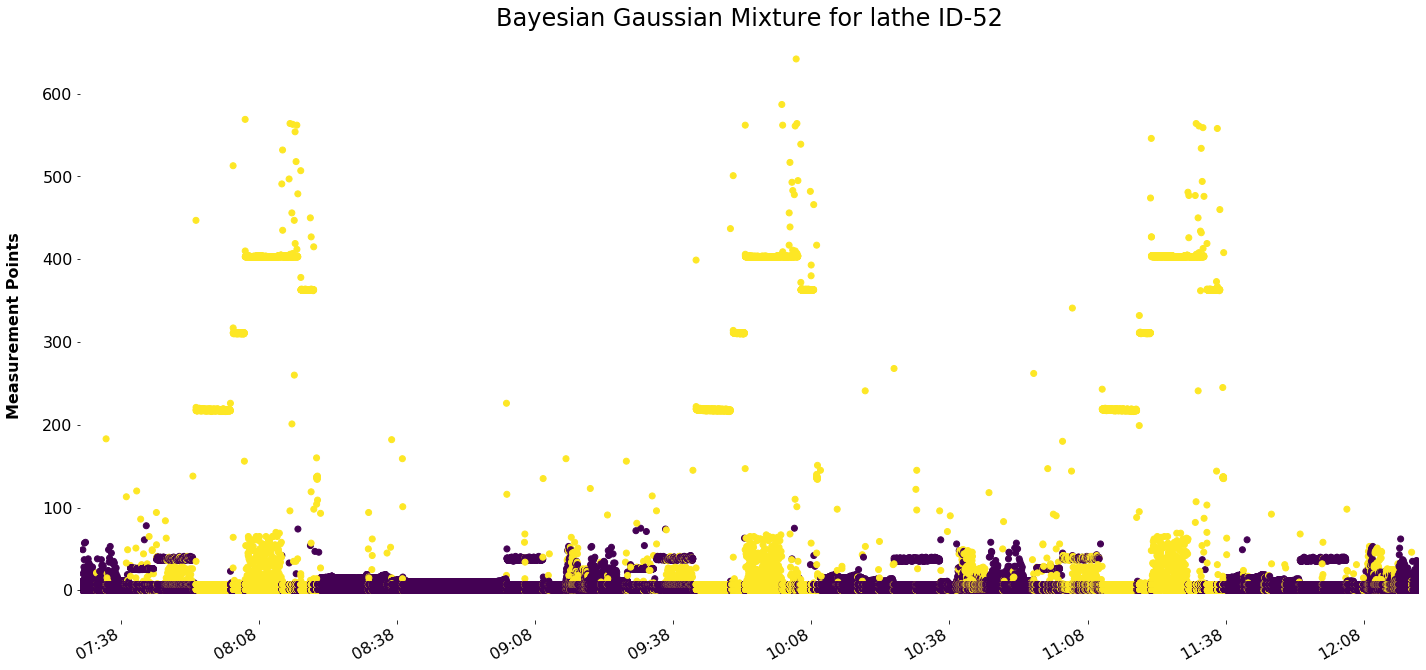

In [29]:
# Model parameterization and fitting:
BayesianGM = bgm(init_params='kmeans', max_iter=100, n_components=2, random_state=1)
BayesianGM.fit(df_52_model[df_cols])
y_pred_BGM = BayesianGM.predict(df_52_model[df_cols])

# Visualizing BGM:
lathe_data_vizual(df_52, df_52_model, df_52_model, df_52_model, df_52_model, 52, 'm_on', 
                  model_pred=y_pred_BGM, model_name='Bayesian Gaussian Mixture')

When just eyebolling this plot we can see Bayesian Gaussian Mixture algorithm has divided all data points in 2 parts which could treated as 'ON/OFF' mode. We can question the choice of some points clustering or we can gust agree with algorithm's decision in clustering. There are point lines presented that could be considered as ON among data points placed approximately under 80 and marked as OFF with *purple dark*. We can use this algorithm to determine lathe operational mode, because BGM has lightened with *yellow* all 3 metal parts which were processed during this day.<br> 
Algorithm scored 0.72 points - the 4-th result.
___

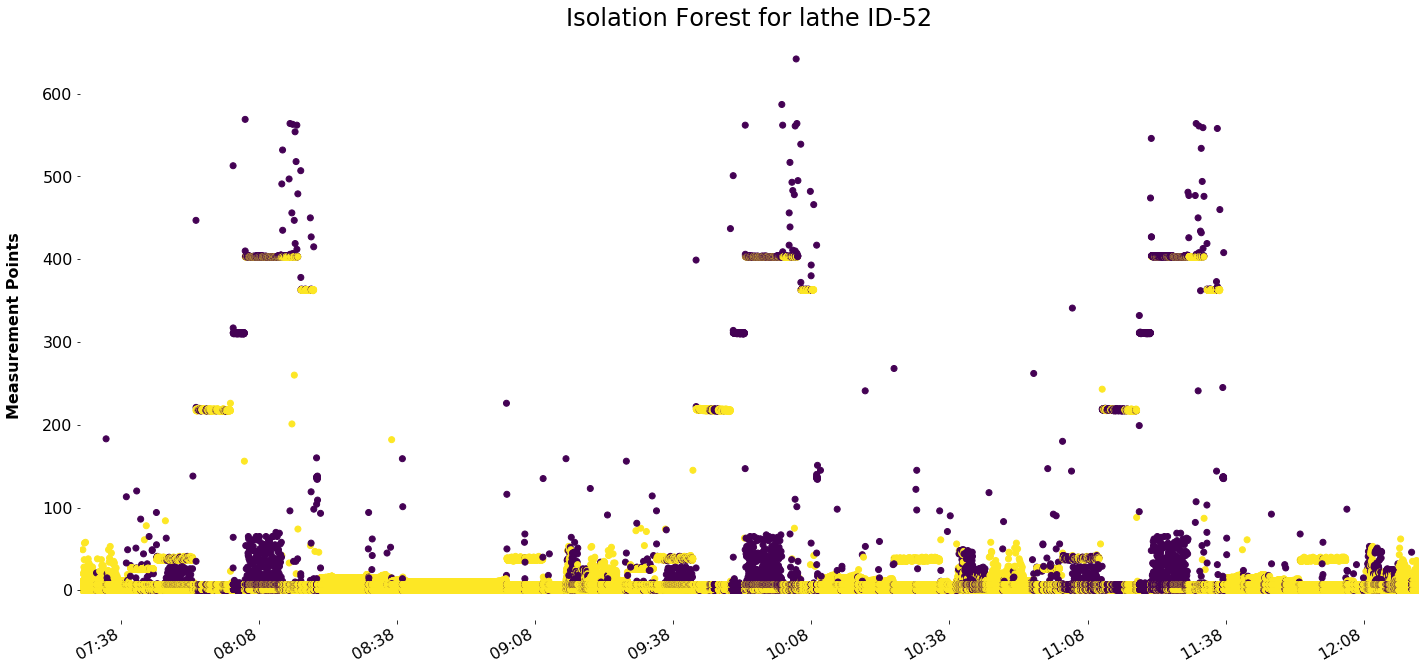

In [30]:
# Model parameterization and fitting:
isf = IsolationForest(n_estimators=150)
isf.fit(df_52_model[df_cols])
y_pred_ISF = isf.predict(df_52_model[df_cols])
    
# Visualizing BGM:
lathe_data_vizual(df_52, df_52_model, df_52_model, df_52_model, df_52_model, 52, 'm_on', 
                  model_pred=y_pred_ISF, model_name='Isolation Forest')

Isolation Forest colorization looks lire reversed BGM clustering but with slight difference. There are mixed 'ON/OFF' point lines arount 200 and 400 which certanly must be marked as ON mode.<br>
Isolation Forest scored 0.30 points which is the worst result. Defenetly not for our task.
___

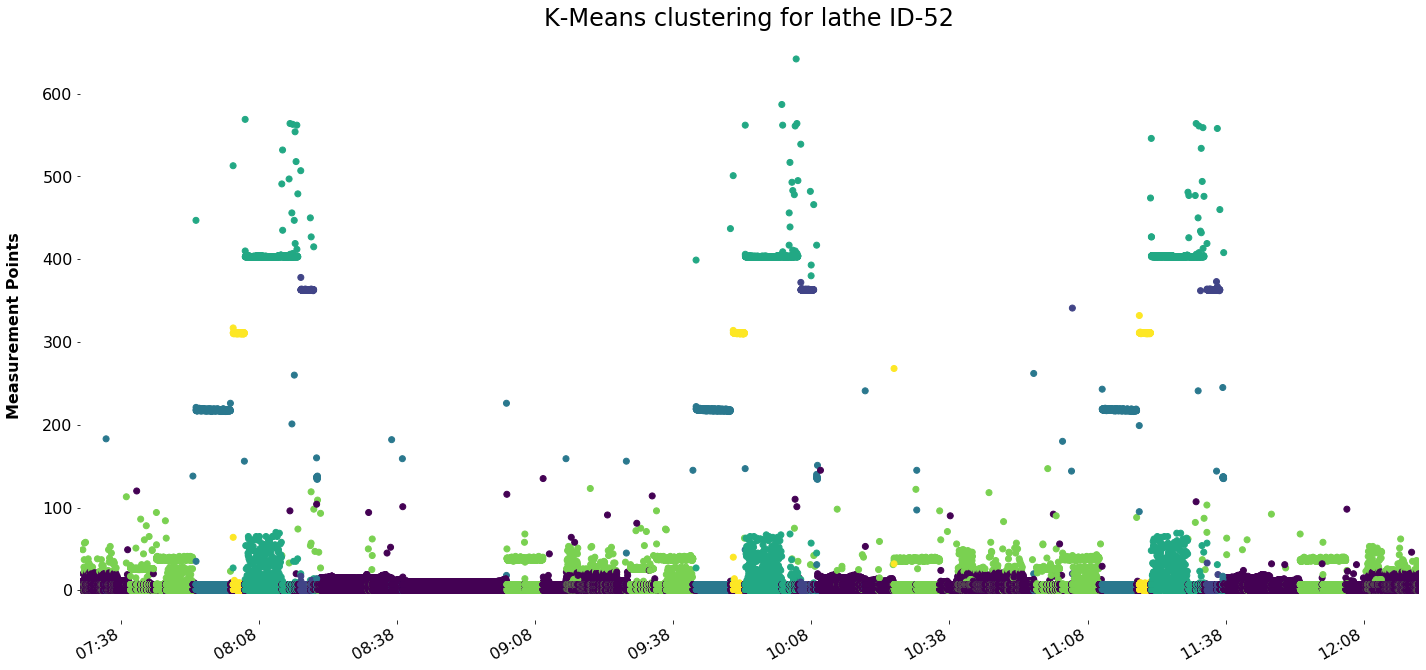

In [31]:
# Model parameterization and fitting:
km = KMeans(n_clusters=6, max_iter=300, n_init=10, random_state=1)
km.fit(df_52_model[df_cols])
y_pred_KM = km.predict(df_52_model[df_cols])
    
# Visualizing K-Means:
lathe_data_vizual(df_52, df_52_model, df_52_model, df_52_model, df_52_model, 52, 'm_on', 
                  model_pred=y_pred_KM, model_name='K-Means clustering')

K-means clustering algorithm has marked data points not as 'ON/OFF' but as something that could be treaten as metal part operation profile. We can see there were 3 metal parts processed with their own profiles which are almost identical. We can definitely use K-means for our task.<br>
K-means scored 0.832 points which is the highest result.
___

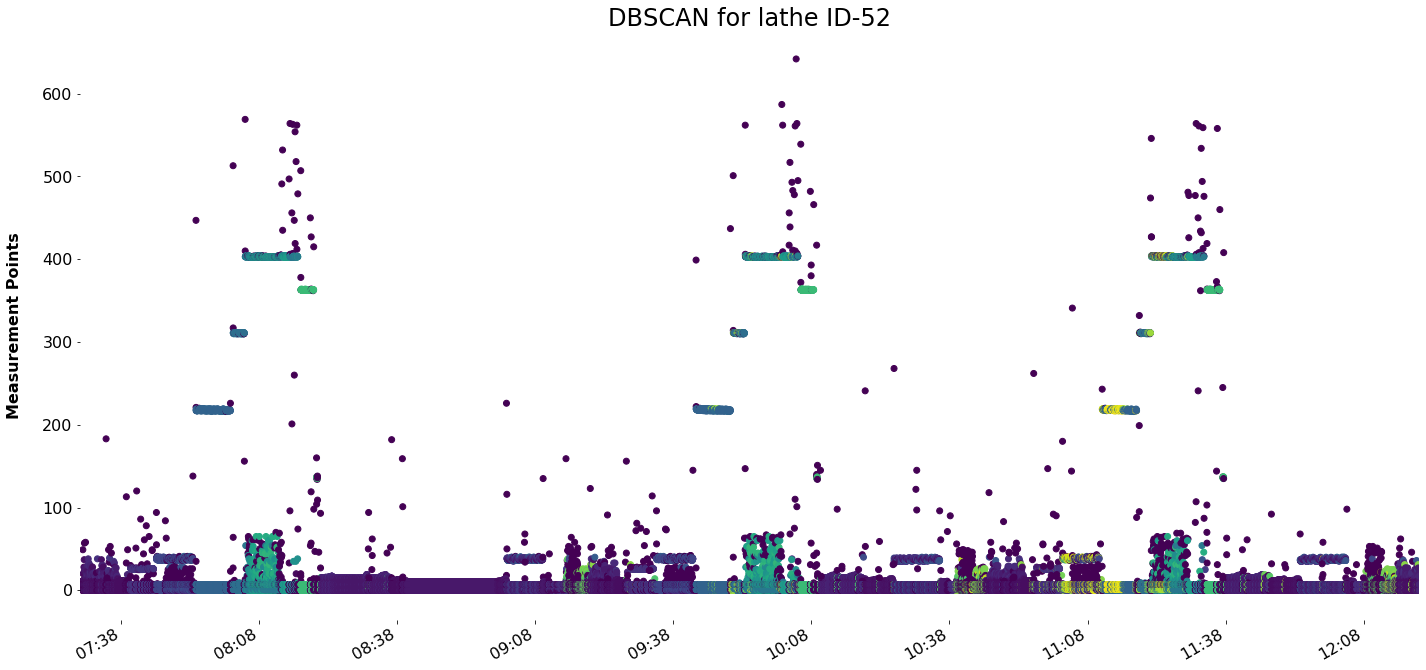

In [32]:
# Model parameterization and fitting:
dbs = DBSCAN(eps=0.5, leaf_size=15)
dbs.fit(df_52_model[df_cols])
y_pred_DBSCAN = dbs.fit_predict(df_52_model[df_cols])
    
# Visualizing DBSCAN:
lathe_data_vizual(df_52, df_52_model, df_52_model, df_52_model, df_52_model, 52, 'm_on', 
                  model_pred=y_pred_DBSCAN, model_name='DBSCAN')

DBSCAN algorithm seems to work wery well on marking outliers, even in data point groups and point lines. We also see clearly that 3 metal parts were processed. There are no any obstacles for DBSCAN use, especially when we can filter outliers in data very well.<br>
DBSCAN scored 0.78 points which is the 3-rd result.
___

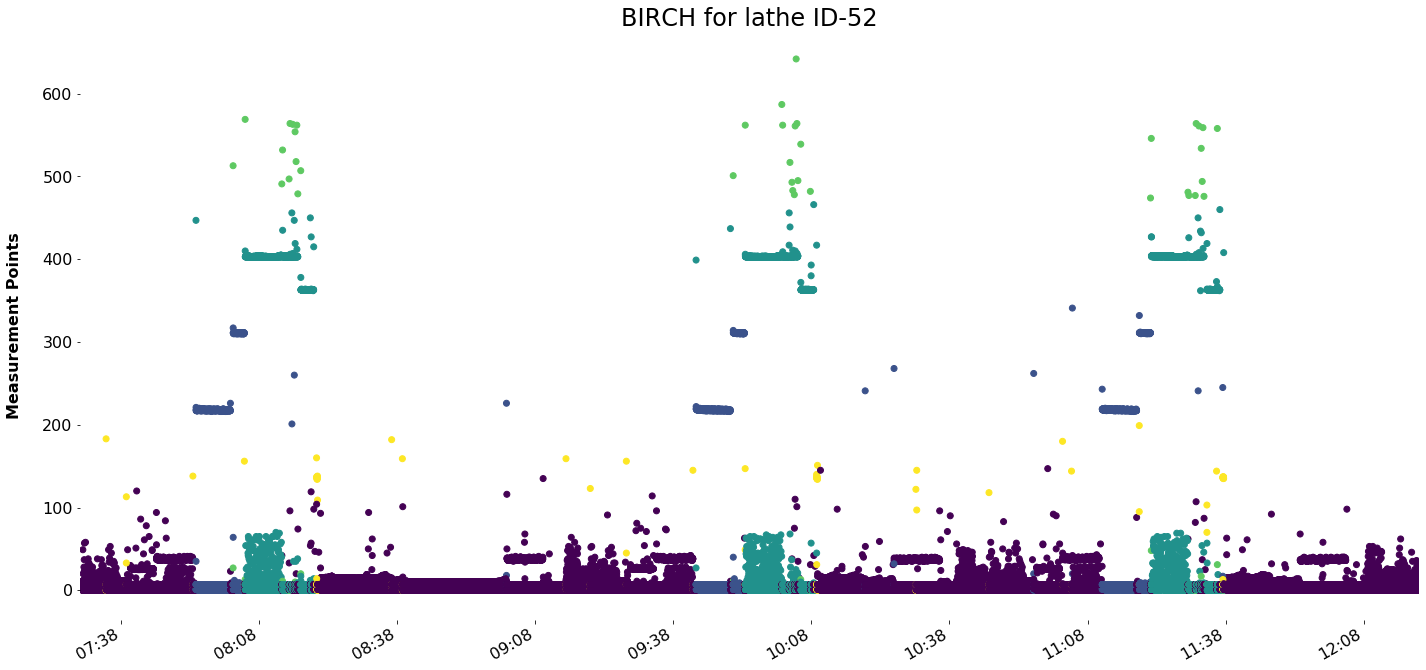

In [33]:
# Model parameterization and fitting:
bir = Birch(n_clusters=5, branching_factor=100)
bir.fit(df_52_model[df_cols])
y_pred_BIRCH = bir.predict(df_52_model[df_cols])
    
# Visualizing BIRCH:
lathe_data_vizual(df_52, df_52_model, df_52_model, df_52_model, df_52_model, 52, 'm_on', 
                  model_pred=y_pred_BIRCH, model_name='BIRCH')

BIRCH algorithm worked less accurate on outliers grouping than DBSCAN, but it actually highlighted several groups of outliers which can be re-marked manually later. We can see here our 3 metal parts profiles. We can also see *purple dark* points whick can be treated as noise data.<br>
BIRCH scored 0.831 points which is the 2-nd place after K-means.
___

## Results testing

Let's test **Bayesian Gaussian Mixture**, **K-means** and **BIRCH** algorithms on different lathe in order to see close to ID-52 results. We'll start with visualization. Lathe with all 4 working sensors and with 70k+ data points is **ID-56**.

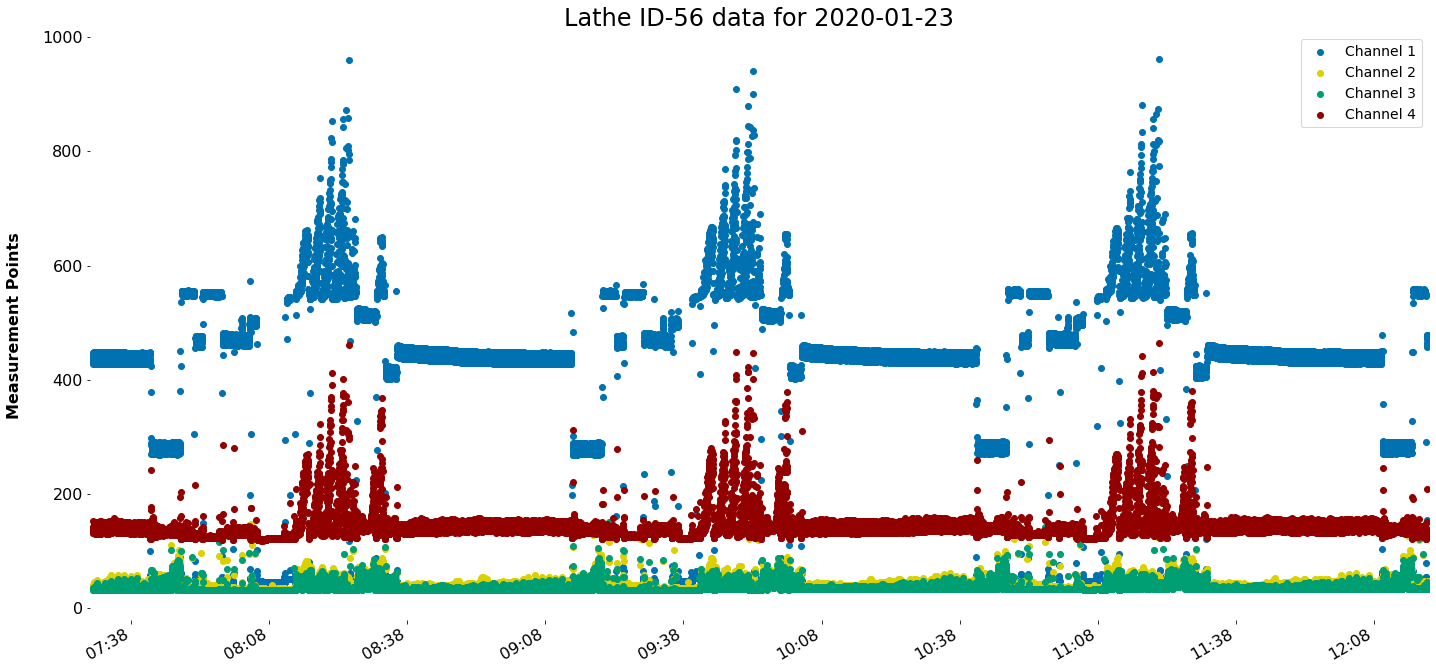

In [34]:
df_56 = df[df['id_equip'] == 56].copy()
df_56 = df_56.reset_index(drop=True)

# Extacting channnnels for plotting:
df_56_1 = df_56[df_56['chanel'] == 1]
df_56_2 = df_56[df_56['chanel'] == 2]
df_56_3 = df_56[df_56['chanel'] == 3]
df_56_4 = df_56[df_56['chanel'] == 4]

lathe_data_vizual(df_56, df_56_1, df_56_2, df_56_3, df_56_4, 56, 'm_off')

Now we'll use selected algorithms for ID-56 lathe data clustering.

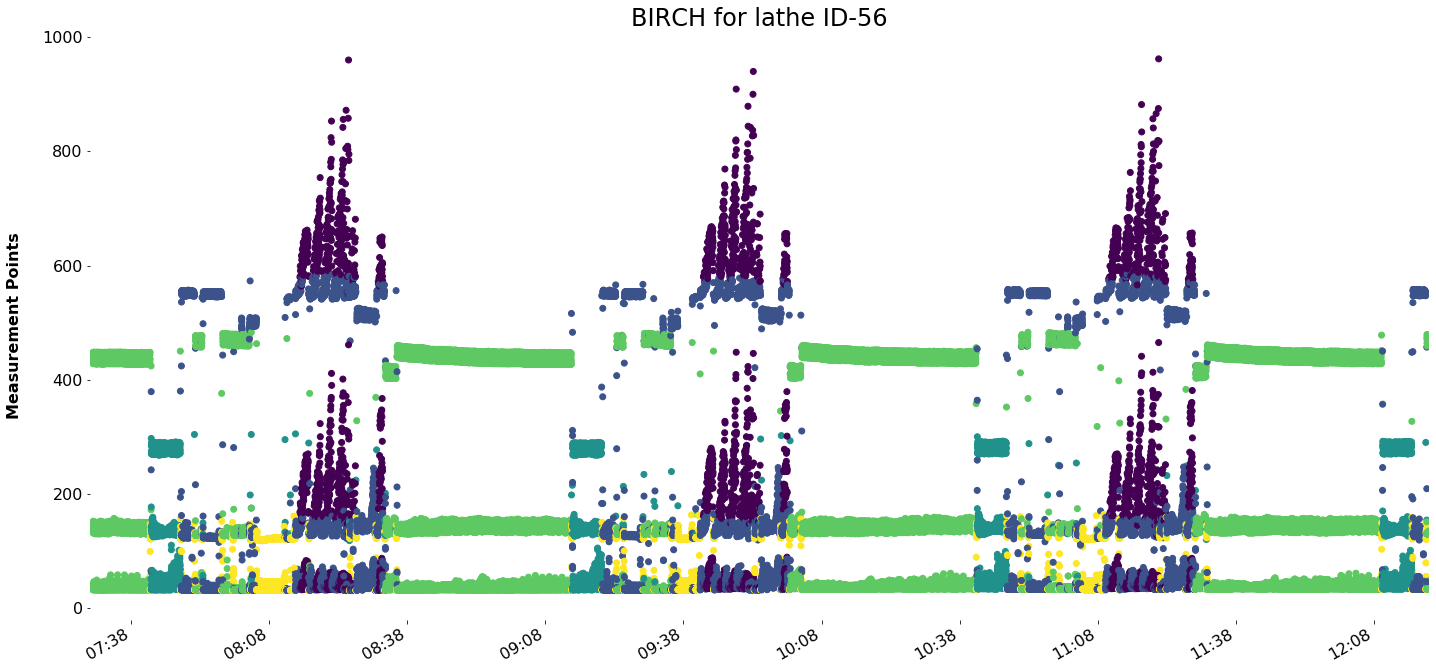

In [35]:
# We need new dataframe for algorithm:
df_56_model = pd.DataFrame()

# Resetting indexes for future merging:
df_56_1 = df_56_1.reset_index(drop=True)
df_56_2 = df_56_2.reset_index(drop=True)
df_56_3 = df_56_3.reset_index(drop=True)
df_56_4 = df_56_4.reset_index(drop=True)

# Combining all together:
df_56_model = pd.concat([df_56_1['value'], df_56_2['value'], df_56_3['value'], 
                       df_56_4['value']], axis=1, ignore_index=True)

# Final preparations:
df_56_model.columns = ['chanel_1', 'chanel_2', 'chanel_3', 'chanel_4']
df_56_model['date_time'] = df_56_1['date_time']
df_56_model.head()

df_cols = ['chanel_1', 'chanel_2', 'chanel_3', 'chanel_4']

# Model parameterization and fitting:
bir_test = Birch(n_clusters=5, branching_factor=100)
bir_test.fit(df_56_model[df_cols])
y_pred_BIRCH_test = bir_test.predict(df_56_model[df_cols])
    
# Visualizing BIRCH:
lathe_data_vizual(df_56, df_56_model, df_56_model, df_56_model, df_56_model, 56, 'm_on', 
                  model_pred=y_pred_BIRCH_test, model_name='BIRCH')

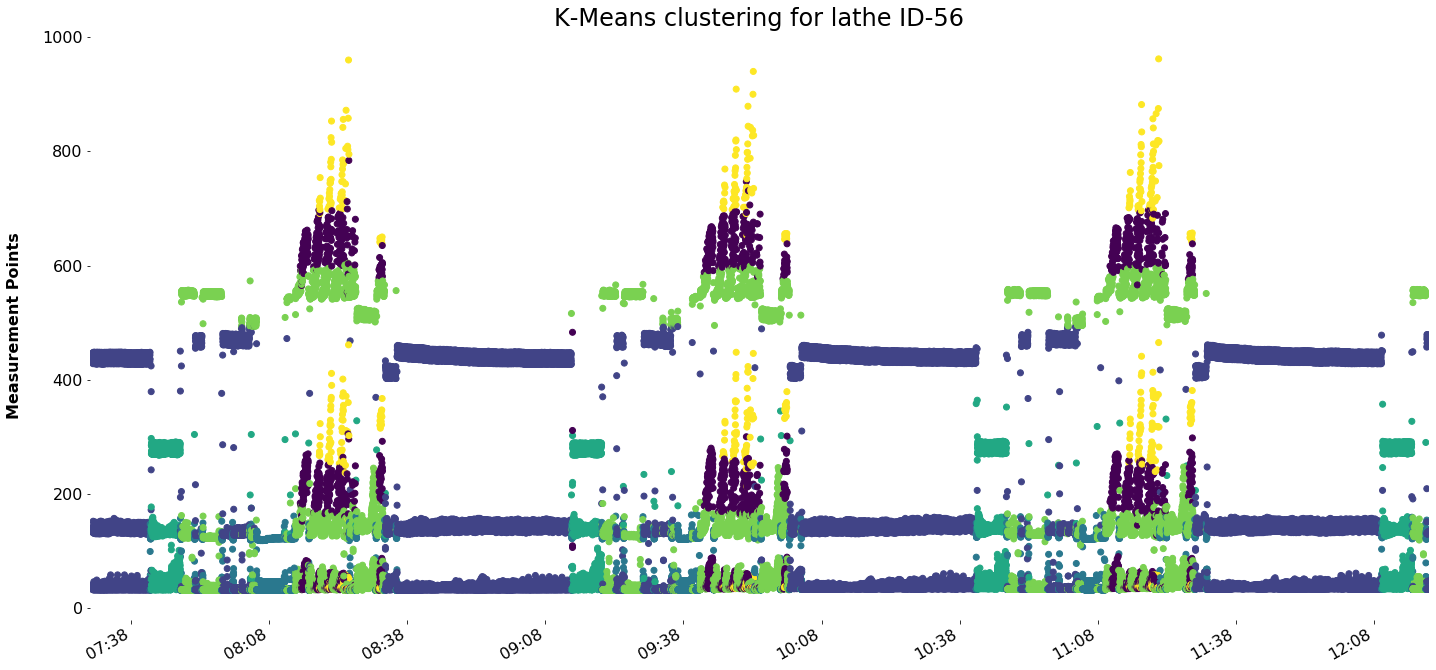

In [37]:
# Model parameterization and fitting:
km_test = KMeans(n_clusters=6, max_iter=300, n_init=10, random_state=1)
km_test.fit(df_56_model[df_cols])
y_pred_KM_56_test = km_test.predict(df_56_model[df_cols])
    
# Visualizing K-Means:
lathe_data_vizual(df_56, df_56_model, df_56_model, df_56_model, df_56_model, 56, 'm_on', 
                  model_pred=y_pred_KM_56_test, model_name='K-Means clustering')

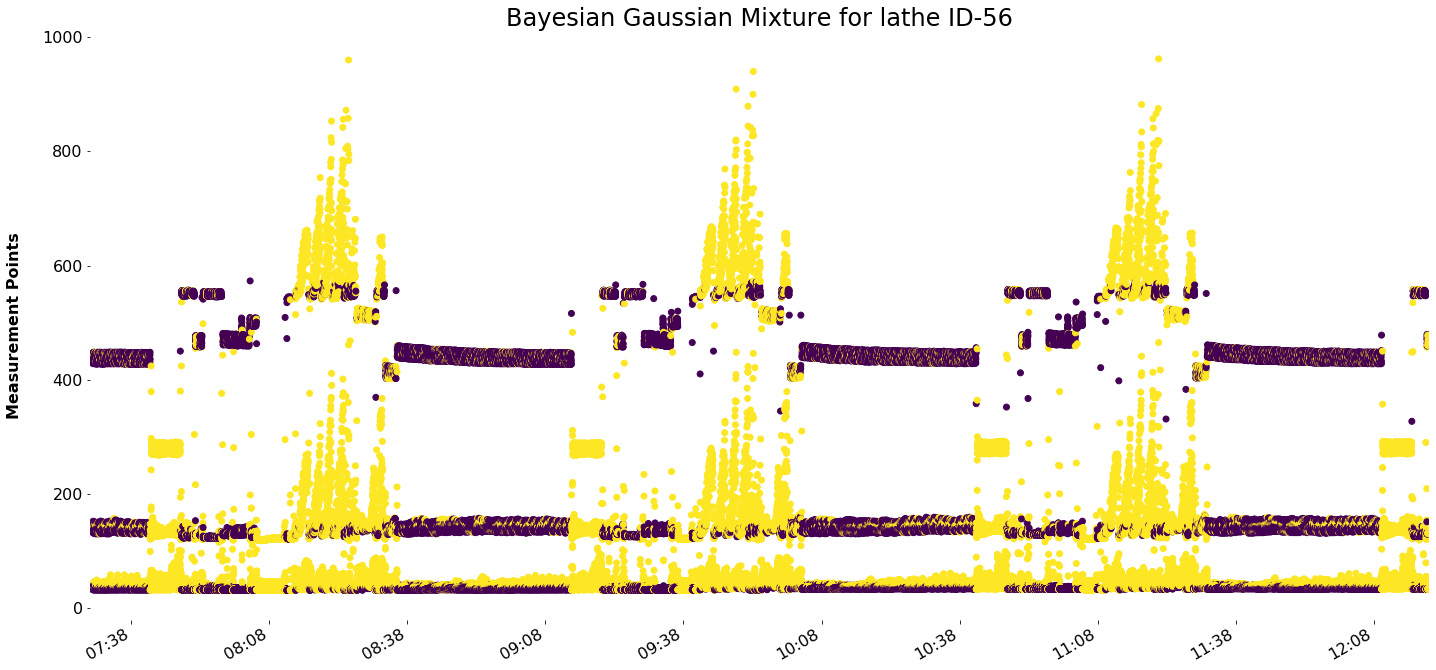

In [38]:
# Model parameterization and fitting:
BayesianGM_test = bgm(init_params='kmeans', max_iter=100, n_components=2, random_state=1)
BayesianGM_test.fit(df_56_model[df_cols])
y_pred_BGM_test = BayesianGM_test.predict(df_56_model[df_cols])

# Visualizing BGM:
lathe_data_vizual(df_56, df_56_model, df_56_model, df_56_model, df_56_model, 56, 'm_on', 
                  model_pred=y_pred_BGM_test, model_name='Bayesian Gaussian Mixture')

K-means and BIRCH algorithms are working an intended, with proper metal part profile points clustering. Bayesian Gaussian Mixture also marked metal parts operations as some activity, but there are also point lines with mixed results.

## Conclusions

In this research project we used a data (gathered for no purpose) in order to decide if we able to set up questions about data usage on manufacturing enterprise and successfully answering theese questions.

Results of this research will help IT and factory production services of Kirovsky Zavod to visualise current lathes operations, see if there are any breaks during lathes operations, determine if there are not properly processed metal parts (based on metal part profile) and maybe something else.

## Next Steps

Here are some proposials if you want to work on this project little more:
- Modify visualization function and add a tweak of selecting 1, 2, 3 or 4 channels visualized.
- Implement classification algorithms after clusterization as we now have a target column. You can classify is it an ON/OFF mode, or what metal part is processed now based on data of it's profile.
- More detailed hyperparameter tuning in GridSearchCV in order to make algorithms more accurate.
- Try to find clustering algorithm which will perform better than K-means or BIRCH.
- Visualize data on other lathes that were not touched in this project.